In [1]:
from Functions_base import ic_twofield, omega_base, theta_base, delta_base, Temerge
from Functions_analysis import Y
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from Functions_IPM import run_year_mix2, eps, biocontrol
import matplotlib as mpl
import seaborn as sns

# Import ascospore data
growth_delay = np.load("dd_delay.npy")
prop_asc = np.load("prop_asc.npy")

# Functions for plotting aesthetics
from Functions_plotting import c1,c2,c3,c4,c5
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
this_c = [c2,c3,c4,c5]

# Default scenario

In [2]:
# IPM parameters, one for the "default" scenario, and an array for the low-medium-high scenarios
r_beta = 0.985
r_beta_range = [0.998,0.985,0.972]

sow_delay = 7
sow_delay_range = [0,7,3]

prop_debris = 0.1
prop_debris_range=[0,0.1,0.777]

debris_removal = 0.154
debris_removal_range = [0.154,0.154,0]

biocontrol_dates = [31]
biocontrol_dates_range = [[39],[31],[31,39]]

[[0.02       0.97599856 0.97983694]
 [0.04       0.97602405 0.97986252]
 [0.06       0.97604928 0.979888  ]
 [0.08       0.9760739  0.97991302]
 [0.1        0.97609807 0.97993771]
 [0.12       0.97612173 0.97996212]
 [0.14       0.97614444 0.97998568]
 [0.16       0.97616654 0.98000888]
 [0.18       0.97618788 0.98003147]
 [0.2        0.97620823 0.9800533 ]
 [0.22       0.97622751 0.98007426]
 [0.24       0.97624591 0.98009459]
 [0.26       0.97626283 0.98011368]
 [0.28       0.97627841 0.98013168]
 [0.3        0.9762926  0.9801486 ]
 [0.32       0.97630536 0.98016437]
 [0.34       0.97631626 0.98017862]
 [0.36       0.97632516 0.98019119]
 [0.38       0.97633176 0.98020181]
 [0.4        0.97633656 0.98021105]
 [0.42       0.97633872 0.98021805]
 [0.44       0.97633802 0.98022263]
 [0.46       0.97633455 0.98022487]
 [0.48       0.97632786 0.98022444]
 [0.5        0.97631778 0.98022116]
 [0.52       0.9763039  0.98021467]
 [0.54       0.97628566 0.98020442]
 [0.56       0.97626315 0.98

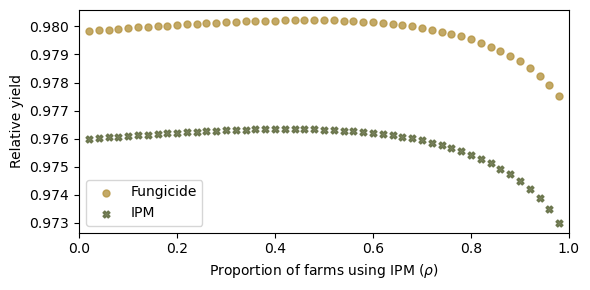

In [3]:
# Run simulation for each proportion
it = 0.02
prop = np.arange(it,1.0,it)
all_YI = np.zeros(len(prop))
all_YF = np.zeros(len(prop))
Nprop = len(prop)

for i in range(len(prop)):
    p = prop[i]
    ic = 1*ic_twofield
    t,pop = run_year_mix2(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,p,omega_base,theta_base,delta_base)
    
    # Compute yields
    all_YI[i] = Y(pop[:,:6])/p
    all_YF[i] = Y(pop[:,6:])/(1-p)

# Plot figure
fig,ax = plt.subplots(1,figsize = (6,3))
ax.scatter(prop,all_YF,label="Fungicide",c=c2,alpha=0.8,s=25)
ax.scatter(prop,all_YI,label="IPM",c=c4,marker='X',alpha=0.8,s=25)
print(np.stack((prop,all_YI,all_YF)).T)
ax.set_xlabel(r"Proportion of farms using IPM ($\rho$)")
ax.set_ylabel("Relative yield")
ax.legend(loc = "lower left")
ax.set_xlim([0,1])
plt.tight_layout()

# Save figure
fig.savefig('Figures/Manuscript_final/fig_defaultresult.pdf', dpi=400,bbox_inches='tight')

In [4]:
# Run simulations across all proportions, get yield and FOI over time
def get_Y_FOI(r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,omega,theta,delta,per_capita):
    
    # Set up storage vectors
    all_YI = np.zeros(Nprop)
    all_YF = np.zeros(Nprop)
    FOI_plain = np.zeros((Nprop,4,Ntime)) # Order: I_I, P_I, I_F, P_F
    FOI_b = np.zeros((Nprop,4,Ntime))
    FOI_f = np.zeros((Nprop,4,Ntime))
    
    # Run across all proportions
    for k in range(Nprop):
        p = prop[k]
        all_YI[k], all_YF[k], FOI_plain[k], FOI_b[k], FOI_f[k] = get_Y_FOI_p(p,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,omega,theta,delta,per_capita)
    
    return all_YI, all_YF, FOI_plain, FOI_b, FOI_f

# Compute yield and FOI for a given proportion
def get_Y_FOI_p(p,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,omega,theta,delta,per_capita):
        
    # Run simulation
    ic = 1*ic_twofield
    _,pop = run_year_mix2(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,p,omega,theta,delta)

    # Compute yields
    all_YI = Y(pop[:,:6]/p)
    all_YF = Y(pop[:,6:]/(1-p))

    # Compute fungicide and biocontrols
    fungicide = np.zeros(len(t_growing))
    for i in range(len(fungicide)):
        fungicide[i] = 1-eps(t_growing[i],omega,theta,delta)

    b = np.zeros(len(t_growing))
    for i in range(len(b)):
        b[i] = 1-biocontrol(biocontrol_dates)(t_growing[i],growth_delay[sow_delay])

    # Compute FOIs
    A = 1*np.sum(pop[:,:6],axis=1) + 1*np.sum(pop[:,6:-1],axis=1)
    these_pop = 1*pop[:,[2,5,8,11]].T
    these_pop[0] *= r_beta
    these_pop[1] *= r_beta

    FOI_out = these_pop
    FOI_b = FOI_out*b*r_beta
    FOI_f = FOI_out*fungicide
        
    return all_YI, all_YF, FOI_out, FOI_b, FOI_f

# Get time vector
t_growing,_ = run_year_mix2(ic_twofield,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,0.5,omega_base,theta_base,delta_base)
Ntime = len(t_growing)

# Varied regime intensities
Plots one 3x3 figure for yields, and one 3x3 figure for FOI contributions from each compartment.

In [5]:
# Checking that the edge cases line up with the single-field yields
p = 0.00001
ic = 1*ic_twofield
t,pop = run_year_mix2(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,p,omega_base,theta_base,delta_base)
print(Y(pop[:,6:]/(1-p)))

p = 1 - p
ic = 1*ic_twofield
t,pop = run_year_mix2(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,p,omega_base,theta_base,delta_base)
print(Y(pop[:,:6]/p))

0.9798110781384989
0.972363695203104


In [6]:
# Plot details
Nipm = 3
Nf = 3
per_capita = True
fung = [0.5,0.75,1]

all_YI = np.zeros((Nipm,Nf,len(prop)))
all_YF = np.zeros((Nipm,Nf,len(prop)))
all_FOI_plain = np.zeros((Nipm,Nf,len(prop),4,Ntime))
all_FOI_b = np.zeros((Nipm,Nf,len(prop),4,Ntime))
all_FOI_f = np.zeros((Nipm,Nf,len(prop),4,Ntime))


for i in range(Nipm):
    for j in range(Nf):        
        all_YI[i,j], all_YF[i,j], all_FOI_plain[i,j], all_FOI_b[i,j], all_FOI_f[i,j] = get_Y_FOI(r_beta_range[i],sow_delay_range[i],prop_debris_range[i],debris_removal_range[i],biocontrol_dates_range[i], omega_base*fung[j], theta_base, delta_base,per_capita)

In [7]:
# Plot yields
def plot_y(ax, all_YI, all_YF,inset = False):
    s=20
    ax.scatter(prop[::2],all_YF[::2],label = "Fungicide \nregime",c=c2,alpha=0.8,s=s)
    ax.scatter(prop[::2],all_YI[::2],label = "IPM regime",edgecolors=c4,marker='X',alpha=0.8,facecolors=c4,s=s)
    ax.set_xlim([0,1])
    ax.set_ylim([0.92,1])
    s1=7
    
    if inset == True:
        # Plot inset
        inset_ax = inset_axes(ax,width='65%',height=0.8, loc="lower right",borderpad=1.1,bbox_to_anchor=(0.02, 0.07, 1, 1), bbox_transform=ax.transAxes)
        inset_ax.scatter(prop[::2],all_YF[::2],c=c2,alpha=0.8,s=s1)
        inset_ax.scatter(prop[::2],all_YI[::2],edgecolors=c4,marker='X',alpha=0.8,facecolors=c4,s=s1)
        inset_ax.set_xlim([0,1])
#         inset_ax.set_ylim([0.965,0.975])
        
    return ax

# Plot FOI on a [type] of farm
def plot_FOI(ax,FOI):
    labels = ["I_I","P_I","I_F","P_F"]
    for k in range(4):
        ax.fill_between(prop,np.sum(FOI[:,:k],axis=1),np.sum(FOI[:,:k+1],axis=1),label = labels[k],color=this_c[k])
    ax.set_xlim([0,1])
    return ax

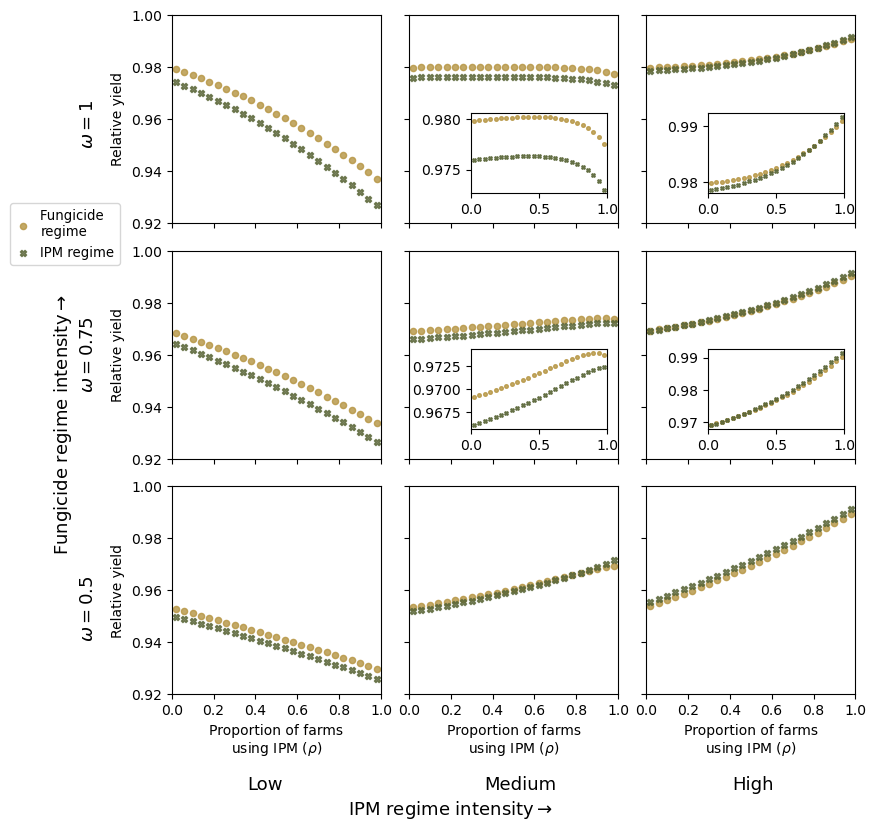

In [8]:
# Set up figures
figY,axesY = plt.subplots(1,figsize = (9,9))
locs = [["upper left", "upper center", "upper right"],["center left", "center", "center right"],["lower left", "lower center", "lower right"]]

for i in range(Nipm):
    for j in range(Nf):        
        YI, YF, FOI_plain, FOI_b, FOI_f = all_YI[i,j], all_YF[i,j], all_FOI_plain[i,j], all_FOI_b[i,j], all_FOI_f[i,j]#get_Y_FOI(r_beta_range[i],sow_delay_range[i],prop_debris_range[i],debris_removal_range[i],biocontrol_dates_range[i], omega_base*fung[j], theta_base, delta_base,per_capita)
        
        # Yield plots - with and without insets, done manually
        if (i == 1 or i == 2) and (j != 0):
            plot_second_inset = True
        else:
            plot_second_inset = False
        inset_axY = inset_axes(axesY,width='30%',height='30%',loc=locs[Nf-1-j][i],borderpad=0.5,bbox_to_anchor=(0.09, 0.1, 1, 1), bbox_transform=axesY.transAxes)
        inset_axY = plot_y(inset_axY,YI, YF, plot_second_inset)
       
        # Show y axis labels where relevant
        if i != 0:
            inset_axY.tick_params(labelleft=False)
        else:
            inset_axY.set_ylabel("Relative yield")
            
        # Show x axis labels where relevant
        if j != 0:
            inset_axY.tick_params(labelbottom=False)
        else:
            inset_axY.set_xlabel("Proportion of farms\nusing IPM ("+r"$\rho$)")
        
# Yield figure details
axesY.set_xlabel("IPM regime intensity"+ r"$\rightarrow$" ,fontsize=13)
axesY.set_ylabel("Fungicide regime intensity" + r"$\rightarrow$",fontsize=13)
axesY.set_xticks([0.7,1.8,2.8,3],labels=["Low","Medium","High",""],fontsize=13)
axesY.set_yticks([0.7,1.8,2.8,3],labels=["$\omega = 0.5$","$\omega = 0.75$","$\omega = 1$",""],fontsize=13,rotation=90,va='center')
axesY.tick_params(axis=u'both', which=u'both',length=0)

axesY.spines["top"].set_visible(False)
axesY.spines["right"].set_visible(False)
axesY.spines["bottom"].set_visible(False)
axesY.spines["left"].set_visible(False)

inset_axY.legend(loc = [-3.04,-0.2],fontsize=9.5,handlelength=1.1)

# Save figure
figY.savefig('Figures/Manuscript_final/fig_3x3.pdf', dpi=400)

In [9]:
for i in range(3):
    for j in range(3):
        print(i,j)
        print(np.array([prop,all_YI[i,j],all_YF[i,j]]).T)
        print("")

0 0
[[0.02       0.94989014 0.95282599]
 [0.04       0.94945178 0.95240522]
 [0.06       0.94901137 0.95198233]
 [0.08       0.94856784 0.95155649]
 [0.1        0.94812197 0.95112839]
 [0.12       0.9476737  0.95069797]
 [0.14       0.94722287 0.9502649 ]
 [0.16       0.94676952 0.94982945]
 [0.18       0.94631323 0.94939114]
 [0.2        0.94585493 0.94895083]
 [0.22       0.94539387 0.9485079 ]
 [0.24       0.94493018 0.94806236]
 [0.26       0.94446412 0.94761443]
 [0.28       0.94399555 0.94716408]
 [0.3        0.94352443 0.94671134]
 [0.32       0.94305102 0.94625623]
 [0.34       0.94257506 0.94579869]
 [0.36       0.94209627 0.9453384 ]
 [0.38       0.94161536 0.944876  ]
 [0.4        0.94113175 0.94441097]
 [0.42       0.94064553 0.94394341]
 [0.44       0.94015709 0.94347369]
 [0.46       0.93966649 0.9430018 ]
 [0.48       0.93917281 0.94252695]
 [0.5        0.93867683 0.94204986]
 [0.52       0.93817851 0.94157046]
 [0.54       0.93767763 0.94108858]
 [0.56       0.93717444 